In [31]:
#임포트

import os
import glob
import time

import random
import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


# STEP 1. ---------- 데이터셋 구성하기 ----------

In [32]:
#데이터 로드

cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

In [33]:
# cifar10: 각 픽셀은 0~255 사이의 정숫값

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [34]:
#-1~1 사이 값으로 정규화

train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [35]:
#데이터셋의 shape
#cifar10: 50,000 장의 32x32x3채널(RGB)픽셀 이미지

train_x.shape

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

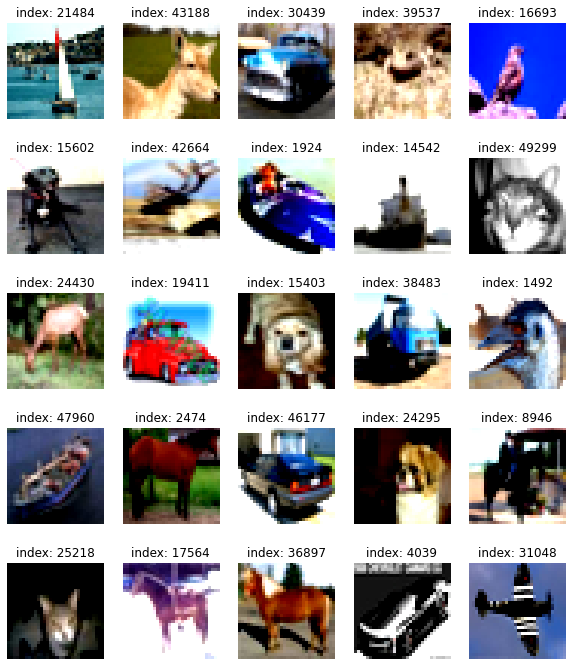

In [62]:
plt.figure(figsize=(10, 12))

for i in range(25):
    # [[YOUR CODE]]
    n = random.randint(0, train_x.shape[0]-1)
    plt.subplot(5, 5, i+1)
    plt.imshow(train_x[n]+0.5)
    plt.title(f'index: {n}') # 이미지에 제목으로 라벨 값
    plt.axis('off')

plt.show()

In [37]:
#------------- 데이터 전처리 끝 -------------#

In [38]:
#모델 학습을 위한 텐서플로우의 Dataset 이용해 준비

In [39]:
BUFFER_SIZE = 50000 #50000인 이유: 전체 데이터를 섞기 위해
BATCH_SIZE = 256 #BATCH는 묶음이고 모델이 한 번에 학습할 양


In [40]:
#from_tensor_slices() 함수를 사용하면 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있음
#아래 코드는 train_x 라는 넘파이 배열(numpy ndarray)형 자료를 섞고, 이를 배치 사이즈에 따라 나누도록 합니다.

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [41]:
#------------- 데이터 준비까지 끝 -------------#

## STEP 3. ------------- 생성자 모델 구현하기 -------------

In [42]:
#모델 Generative Adversarial Network, GAN 만들기

In [43]:
#모델 만드는 함수 정의

def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # Dense layer
    model.add(layers.Dense(2*2*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Reshape layer
    model.add(layers.Reshape((2, 2, 1024)))

    # Conv2DTranspose layer 제일 중요한 레이어, 일반적인 conv2d와는 반대로 이미지 사이즈를 넓혀주는 층
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization()) #정규화 BN
    model.add(layers.LeakyReLU()) #활성화함수 LeakyReLU

    # Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization()) #정규화 BN
    model.add(layers.LeakyReLU()) #활성화함수 LeakyReLU
    
    # Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization()) #정규화 BN
    model.add(layers.LeakyReLU()) #활성화함수 LeakyReLU

    # Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh')) #활성화함수 tanh: -1~1 이내의 픽셀 값으로 정규화시켰던 데이터셋과 동일하게 하기 위함

    return model

In [44]:
#모델 생성 및 세부 내용 확인

generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              409600    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 1024)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 256)         6553600   
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 4, 256)         0

In [45]:
#shape=(1, 100)의 형상을 가지는 랜덤 노이즈 벡터를 생성 -> 결과물을 만들어 보기 위함. But 모델 학습 전이라 결과물도 큰 의미가 있진 않음
noise = tf.random.normal([1, 100]) 
#tf.random.normal을 이용하면 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만들 수 있음

In [46]:
generated_image = generator(noise, training=False) #학습하는 중이 아니니 False 전달
#batch normalization 레이어는 훈련시기와 추론 시기의 행동이 다름
generated_image.shape #batch size 1, (32, 32, 3)사이즈의 이미지가 생성됨

TensorShape([1, 32, 32, 3])

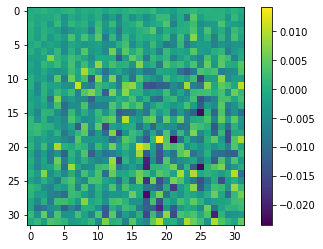

In [67]:
plt.imshow(generated_image[0, :, :, 0]) 
#matplotlib 라이브러리는 2차원 이미지만 보여줄 수 있으므로 0번째와 3번째 축의 인덱스를 0으로 설정
plt.colorbar()
plt.show()

## STEP 4. ------------- 판별자 모델 구현하기 -------------

In [68]:
#판별자 생성 함수
#판별자는 앞서 알아봤듯 가짜 이미지와 진짜 이미지를 입력받으면 각 이미지 별로 '진짜라고 판단하는 정도'값을 출력
#입력은 (32, 32, 3) 크기의 이미지가, 출력은 단 하나의 숫자(진짜라고 판단하는 정도)가 될 것


def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
        # Conv2D Layer
    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten Layer
    model.add(layers.Flatten())

    # Dense Layer
    model.add(layers.Dense(1))

    return model

In [69]:
#판별자 생성 및 세부 내용 확인

discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)        

In [70]:
#아까 생성했던 가짜 이미지를 판별자에 입력하여 결과 확인해보기
#텐서플로우의 텐서 형태로 출력됨. 이 값 또한 아직은 아무런 의미가 없는 값

decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00037729]], dtype=float32)>

In [71]:
#이제 생성자와 판별자 두 가지 네트워크 준비가 완료되었고
#모델을 학습 시키는 일만 남음
#딥러닝 모델이 학습하기 위해서 꼭 필요한 2가지, 바로 손실 함수와 최적화 함수

# STEP 5-ㄱ. ------------- 손실함수 구현 -------------

In [72]:
#손실함수

In [73]:
#손실함수에 사용할 교차 엔트로피 함수는 tf.keras.losses 라이브러리 안에 
#다만, 우리가 교차 엔트로피를 계산하기 위해 입력할 값은 판별자가 판별한 값인데
# 판별자 모델의 맨 마지막 Layer에는 값을 정규화시키는 sigmoid나 tanh 함수와 같은 활성화 함수가 없었습니다.
#즉, 구분자가 출력하는 값은 범위가 정해지지 않아 모든 실숫값을 가질 수 있죠

In [74]:
#from_logits를 True로 설정해 주어야 
#BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [75]:
#그럼, 이제 cross_entropy를 활용해 계산할 loss들은 fake_output와 real_output, 두 가지를 활용

#fake_output : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)
#real_output : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)

#그럼 이제, fake_output과 real_output을 각각 1 또는 0에 비교를 해야 하는데, 어떻게 비교할 수 있을까요?

#바로 tf.ones_like()와 tf.zeros_like() 함수를 활용

#이 함수들은 특정 벡터와 동일한 크기이면서 값은 1 또는 0으로 가득 채워진 벡터를 만들고 싶을 때 사용

In [76]:
#어떤 식으로 활용되는지, 한번 실험

vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

In [77]:
#generator_loss
#generator_loss는 fake_output가 1에 가까워지기를 바라므로, 다음과 같이 tf.ones_like와의 교차 엔트로피값을 계산하면 됩니다.
#즉, cross_entropy(tf.ones_like(fake_output), fake_output) 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가짐

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [78]:
#discriminator_loss
#반면, discriminator_loss는 real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 
#두 가지 loss값을 모두 계산합니다. real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교하면 되겠죠!
#최종 discriminator_loss 값은 이 둘을 더한 값

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [79]:
#discriminator accuracy
#만약 판별자가 real output과 fake output을 accuracy가 1.0에 가까울 정도로 정확하게 판별해 낸다면 좋은 것일까요?
#둘 다 0.5에 가까워지는 것이 이상적입니다. fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

# # STEP 5-ㄴ. ------------- 최적화함수 구현 -------------

In [80]:
#최적화 함수

#Adam 함수 또한 tf.keras.optimizers 안에 있습니다.

#중요한 하이퍼 파라미터인 "learning rate"는 0.0001로 설정할 텐데, 
#학습 품질을 올려보고 싶다면 여러 가지로 값을 바꾸어 가며 학습을 진행해 보는 것을 추천합니다.

#또한, 중요한 점 한 가지는 생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 
#optimizer를 따로 만들어주어야 한다는 점입니다.

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [81]:
#또한, 매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인할 것입니다.

#샘플은 한 번에 16장을 생성하도록 하겠습니다.
#생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야 합니다.
#즉, 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만들어 두도록 하겠습니다

noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# STEP 6. ------------- 훈련과정 상세 기능 구현 -------------

In [82]:
#그렇다면 이제 진짜 훈련을 위한 코드를 만들어 보도록 합시다.

#참고:
#텐서플로우 2.0 이후부터는 1.x의 이전 버전과 다르게, session을 사용하지 않습니다. 
#대신, 학습시킬 훈련 함수 위에 @tf.function 이라는 데코레이터를 붙여서 사용합니다. 
#이 데코레이터는 우리가 직접 session을 열어서 학습했다가, 
#학습이 완료되면 다시 닫아주는 등의 번거로운 과정을 내부적으로 처리해서 더욱 편리하게 학습

In [83]:
#하나의 미니 배치 당 진행할 train_step 함수를 먼저 만들어야 합니다.

@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [92]:
# 이렇게 한 단계씩 학습할 train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수를 만들기
# 아까 만들어 놓았던 고정된 seed를 이용해서 결과물을 만들어내므로, 고정된 seed에 대한 결과물이 얼마나 나아지고 있는지를 확인할 수 있음

def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i]+1)/2.0)
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [93]:
#학습과정 체크를 위한 loss와 accuray 그래프를 그리는 시각화 함수

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()



In [94]:
# 다음은 정기적으로 모델을 저장하기 위한 checkpoint를 만들어줍니다

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# STEP 7. ------------- 학습 과정 진행하기 -------------

In [95]:
#(3)학습시키기

In [96]:
#지금까지 한 단계를 학습하는 train_step, 
#샘플 이미지를 생성하고 저장하기 위한 generate_and_save_images(), 
#학습 과정을 시각화하는 draw_train_history(), 
#그리고 모델까지 저장하기 위한 checkpoint까지 모두 준비가 되었으니 이것들을 한곳에 합치기만 하면 됩니다.

In [97]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [104]:
#이제부터는 특별한 것이 별로 없음
#우리가 생성된 샘플을 시각화하거나 원하는 시간을 출력하는 것 뿐

save_every = 5 #모델을 저장하는 간격
EPOCHS = 50 #전체학습 에포크

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

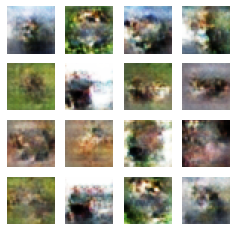

Time for training : 1411 sec


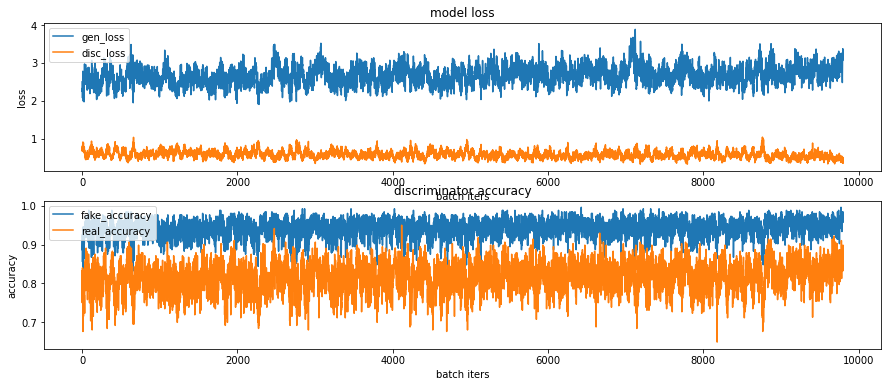

In [105]:
#드디어 GAN 학습 시작
#시간 꽤 걸림

#%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [106]:
#학습이 성공적으로 진행되었나요?

#만약 생성자가 만든 Fake Image에 대한 판별자의 Accuracy(fake_accuracy)가 계속 1에 가깝게 유지되고 있다면, 
#생성자가 만든 이미지가 아직 판별자를 성공적으로 속이지 못하고 있다는 뜻입니다.

#보다 나은 결과물을 만들기 위해서는 더욱 많은 epoch으로 학습을 시켜야 합니다. 
#결과물이 아직 흐릿하다면 더욱 많은 학습을 시켜보세요!
#과연 생성 모델이 이전에는 없던 새로운 디자인의 패션을 만들어내는 것을 확인할 수 있을 거예요..! 
#(물론 시간은 그와 비례하게 늘어나겠죠..?)

#어쩌면 단순히 학습 수행 시간만 늘리는 것보다, 모델 구조나 학습 방법을 바꾸어 봐야 할 수도 있습니다. 
#그래프를 유심히 보면서 학습 결과가 더 이상 개선되고 있지 않은지 여부를 지속적으로 살펴봅시다.

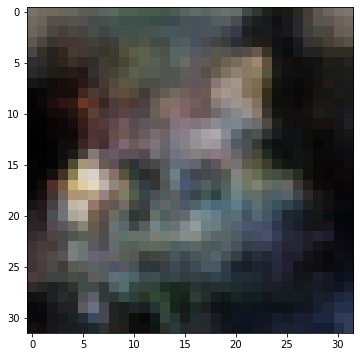

In [110]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [107]:
#학습과정 시각화하기



In [108]:
#학습이 끝난 후 우리가 생성했던 샘플 이미지들을 합쳐 GIF 파일, 일명 움짤로 만들어 보겠습니다. 
#더욱 생생한 학습 진행 과정을 확인해 볼 수 있을 테니까요!

#GIF 파일은 우리가 오래전에 import 해놓았던 imageio 라이브러리를 활용해 만들 수 있습니다.
#imageio.get_writer를 활용해서 파일을 열고, 거기에 append_data로 이미지를 하나씩 붙여나가는 방식입니다.
#아래 코드가 무사히 실행되면, fasion_mnist_dcgan.gif 파일이 저장되어 있는 것을 확인할 수 있을 겁니다!

In [109]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/cifar10_dcgan.gif

-rw-r--r-- 1 root root 1291487 Feb 15 15:18 /aiffel/aiffel/dcgan_newimage/fashion/cifar10_dcgan.gif


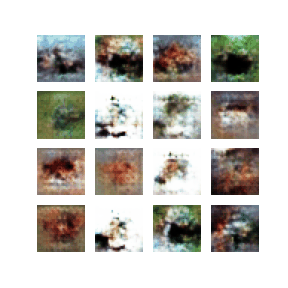